# Import

In [1]:
import os 
import csv
import json
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

from summerize_utlis import *
# You may need to change paths in summerize_utlis.py


5000


In [2]:
All_res_dict = {}

def check_complete(res, all_MC):
    all_id = [item["_id"] for item in all_MC]
    res_id = [item["_id"] for item in res]

    res = [item for item in res if item["_id"] in all_id] # remove extra

    return len(res) == len(all_MC), res
 
for file in os.listdir(workspace):
    if file.startswith("MCresults_") and file.endswith(".jsonl"):
        model_name = file.replace("MCresults_", "").replace(".jsonl", "")
        if "-AWQ" in model_name:
            model_name = model_name.replace("-AWQ", "")
        if "InternVL2_5" in model_name:
            model_name = model_name.replace("InternVL2_5", "InternVL2.5")
        with open(os.path.join(workspace, file), "r") as f:
            res = [json.loads(line) for line in f]
            complete, res = check_complete(res, all_MC)
            if not complete:
                print(f"{model_name} not complete")
                continue
            All_res_dict[model_name] = res

# sort by model name
All_res_dict = dict(sorted(All_res_dict.items(), key=lambda x: x[0]))
# print(All_res_dict.keys())

# Summerize All

In [3]:
# save CSV
statistics_dict = {} 

for model_name, res in All_res_dict.items():
    statistics_dict[model_name] = {"ALL": {"correct": 0, "total": 0}}
    for VQAtype in VQAtype_dict.values():
        statistics_dict[model_name][VQAtype] = {"correct": 0, "total": 0}
    for item in res:
        ALL_MC_item = [i for i in all_MC if i["_id"] == item["_id"]][0]

        if item["response"] == prompt_to_correctChoice(item["prompt"], ALL_MC_item["Answer"]):
            statistics_dict[model_name]["ALL"]["correct"] += 1
            statistics_dict[model_name][ALL_MC_item["QAtype"]]["correct"] += 1
        statistics_dict[model_name]["ALL"]["total"] += 1
        statistics_dict[model_name][ALL_MC_item["QAtype"]]["total"] += 1

statistics_dict = dict(sorted(statistics_dict.items(), key=lambda x: order_modelNames.index(x[0]) if x[0] in order_modelNames else len(order_modelNames)))

import csv

# Save statistics to CSV
csv_file_path = os.path.join(vis_folder, "Result_summary.csv")
with open(csv_file_path, mode="w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    
    # Write the header
    header = ["Model", "ALL"]
    for VQAtype in VQAtype_dict.values():
        header.append(VQAtype)
    csv_writer.writerow(header)
    
    # Write the data
    for model_name, statistics in statistics_dict.items():
        if model_name in reformat_modelName:
            model_name = reformat_modelName[model_name]
        row = [model_name]
        print(f"------------{model_name}------------")
        row.append(f"{statistics['ALL']['correct'] / statistics['ALL']['total'] * 100:.2f}")
        print(f"ALL: {statistics['ALL']['correct'] / statistics['ALL']['total'] * 100:.2f}")    
        for VQAtype in VQAtype_dict.values():
            if VQAtype in statistics:
                row.append(f"{statistics[VQAtype]['correct'] / statistics[VQAtype]['total'] * 100:.2f}")
                print(f"{VQAtype}: {statistics[VQAtype]['correct'] / statistics[VQAtype]['total'] * 100:.2f}")
            else:
                row.append("N/A")
        csv_writer.writerow(row)

print(f"Accuracy statistics saved to {csv_file_path}")

------------Gemini2.5-Pro(03-25)------------
ALL: 81.24
Modality Recognition: 95.60
Anatomy Identification: 82.80
Symptom Recognition: 77.10
Disease Diagnosis: 72.90
Surgery & Operation: 77.80
------------GPT4.1------------
ALL: 77.98
Modality Recognition: 94.60
Anatomy Identification: 77.00
Symptom Recognition: 72.50
Disease Diagnosis: 71.30
Surgery & Operation: 74.50
------------GPT4.1-mini------------
ALL: 75.02
Modality Recognition: 92.50
Anatomy Identification: 73.70
Symptom Recognition: 73.00
Disease Diagnosis: 64.70
Surgery & Operation: 71.20
------------GPT-4o------------
ALL: 74.94
Modality Recognition: 93.20
Anatomy Identification: 74.20
Symptom Recognition: 69.60
Disease Diagnosis: 67.10
Surgery & Operation: 70.60
------------Claude-3.7-Sonnet------------
ALL: 67.72
Modality Recognition: 88.60
Anatomy Identification: 67.10
Symptom Recognition: 64.50
Disease Diagnosis: 55.00
Surgery & Operation: 63.40
------------InternVL3-78B------------
ALL: 72.92
Modality Recognition: 90.3

In [4]:
working_data = []
for item in all_MC:
    working_item = {"_id": item["_id"]}
    working_item['result'] = {}
    working_item["item_accuracy"] = 0
    for model_name, res in All_res_dict.items():
        if model_name in reformat_modelName:
            model_name = reformat_modelName[model_name]
        res_item = [i for i in res if i["_id"] == item["_id"]][0]
        working_item["result"][model_name] = res_item["response"]
        if res_item["response"] == prompt_to_correctChoice(res_item["prompt"], item["Answer"]):
            working_item["item_accuracy"] += 1
            working_item["result"][model_name] = 1
        else:
            working_item["result"][model_name] = 0

    working_data.append(working_item)
    
#  reorder by item_accuracy increasing
reformated_data = sorted(working_data, key=lambda x: x["item_accuracy"])

# count statistics if each accuracy level
statistics = {}
for item in reformated_data:
    if item["item_accuracy"] not in statistics:
        statistics[item["item_accuracy"]] = 0
    statistics[item["item_accuracy"]] += 1
for key, value in statistics.items():
    print(f"{value} VQA -- {key} models correct")
    
with open(os.path.join(vis_folder, "accuracy_data.json"), "w") as f:
    json.dump(reformated_data, f, indent=2)

21 VQA -- 0 models correct
37 VQA -- 1 models correct
48 VQA -- 2 models correct
59 VQA -- 3 models correct
63 VQA -- 4 models correct
65 VQA -- 5 models correct
63 VQA -- 6 models correct
73 VQA -- 7 models correct
66 VQA -- 8 models correct
78 VQA -- 9 models correct
72 VQA -- 10 models correct
86 VQA -- 11 models correct
83 VQA -- 12 models correct
88 VQA -- 13 models correct
91 VQA -- 14 models correct
80 VQA -- 15 models correct
75 VQA -- 16 models correct
93 VQA -- 17 models correct
75 VQA -- 18 models correct
95 VQA -- 19 models correct
100 VQA -- 20 models correct
99 VQA -- 21 models correct
100 VQA -- 22 models correct
92 VQA -- 23 models correct
99 VQA -- 24 models correct
88 VQA -- 25 models correct
98 VQA -- 26 models correct
101 VQA -- 27 models correct
114 VQA -- 28 models correct
96 VQA -- 29 models correct
108 VQA -- 30 models correct
99 VQA -- 31 models correct
114 VQA -- 32 models correct
115 VQA -- 33 models correct
119 VQA -- 34 models correct
115 VQA -- 35 models c

# Summerize Details

In [5]:
# global 
with open(os.path.join(vis_folder, "accuracy_data.json"), "r") as f:
    reformated_data = json.load(f)
Organ_to_key, bodyPart_to_key, modality_to_key, department_to_key = {}, {}, {}, {}

dict_num = build_empty_dict()
dict_num = build_num_dict(dict_num, reformated_data)
dict_num = remove_empty(dict_num, reformated_data)

MODEL_list = [key for key in reformated_data[0]["result"].keys()]
dict_modellen = build_empty_dict(length=len(MODEL_list))   
dict_modellen = remove_empty(dict_modellen, reformated_data) 

In [6]:
dict_fitler = filter_threadhold(dict_num, reformated_data, threadhold=200)
dict_fitler = sort_whole_dict(dict_fitler)


MEDICAL = ["HealthGPT-L14", "HuatuoGPT-Vision-34B"]
OpenSourceGeneral = ["InternVL3-78B", "LLaVA-OV-72B", "Ovis2-34B", "Qwen2.5-VL-72B-Instruct"]
ClosedGeneral = ["Gemini2.5-Pro(03-25)", "GPT4.1", "GPT-4o"]
GeneralThinking = ["Claude3.7-Sonnet-Thinking", "VL-Reasoner-72B", "Skywork-R1V2-38B"]
MedicalThinking = ["MedVLM-R1"]
SelectedModelList = ClosedGeneral + OpenSourceGeneral + MEDICAL + GeneralThinking + MedicalThinking
SingleModel_dict = {}

for model in SelectedModelList:
    # clean output cell
    clear_output(wait=True)
    dict_model = build_empty_dict()
    dict_model = build_model_accuracy_dict(dict_model, reformated_data, model)
    dict_model = remove_empty(dict_model,reformated_data, refer_dict=dict_fitler)
    dict_model = average_dict(dict_model, dict_num)
    dict_model = sort_whole_dict(dict_model)
    SingleModel_dict[model] = dict_model


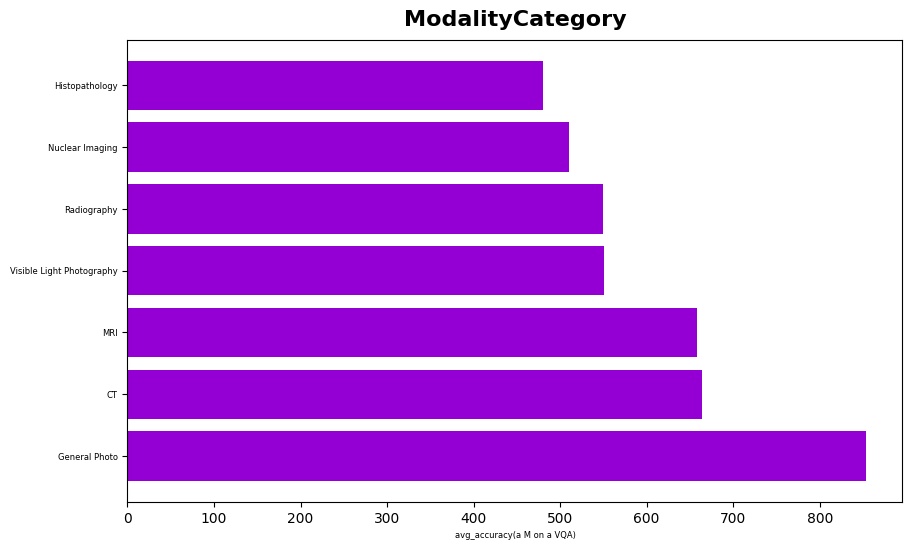

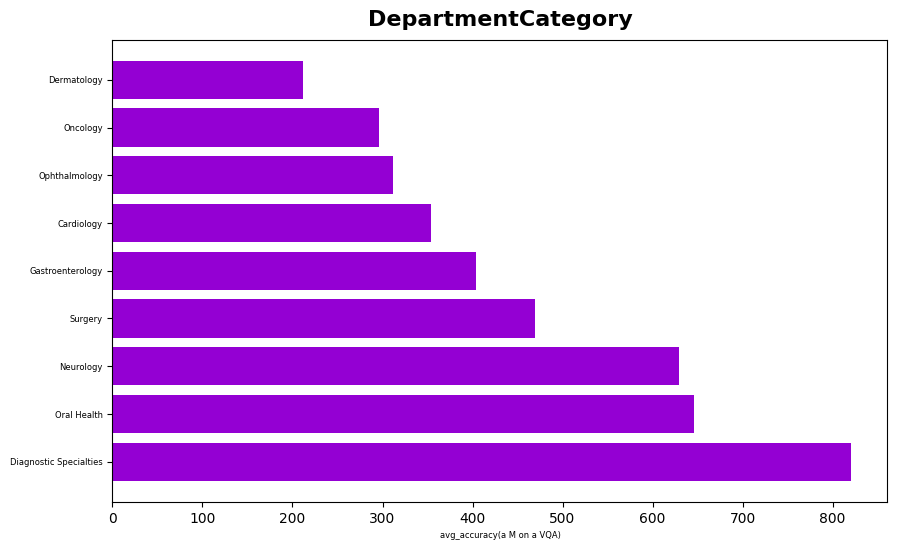

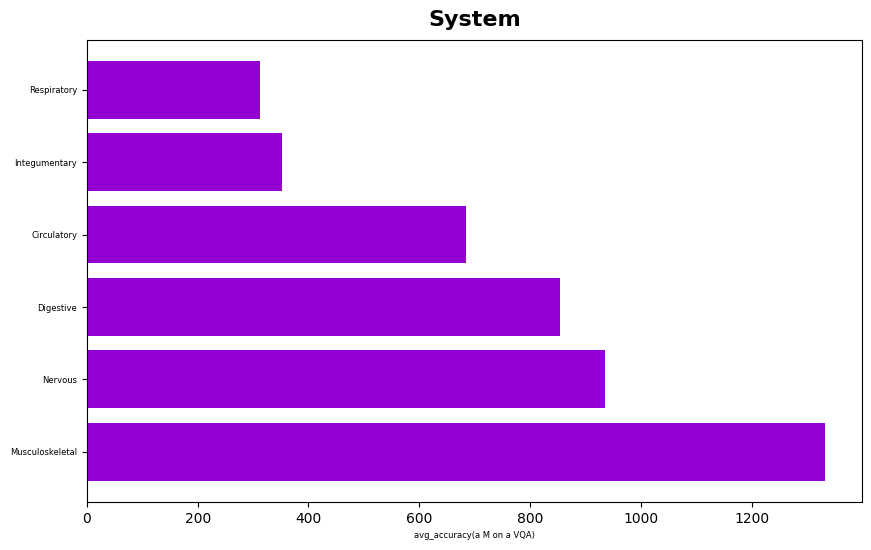

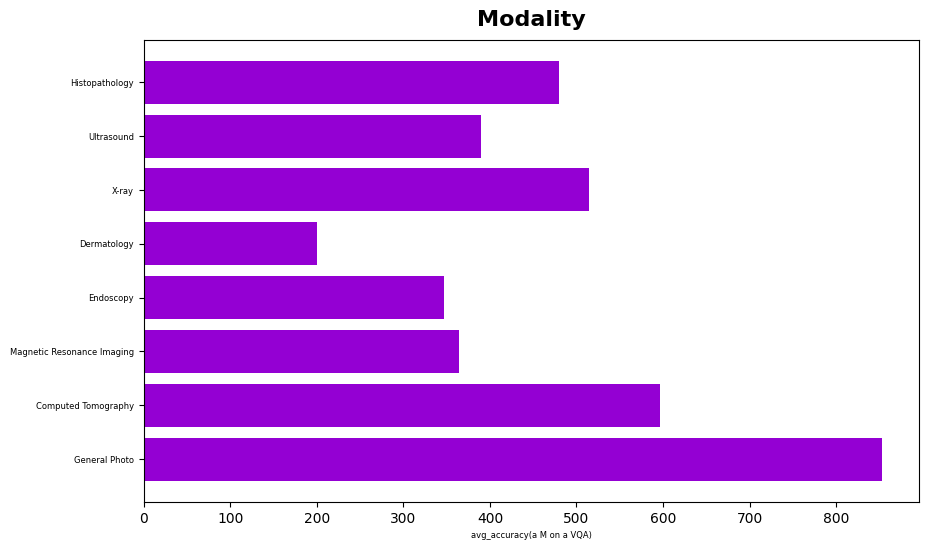

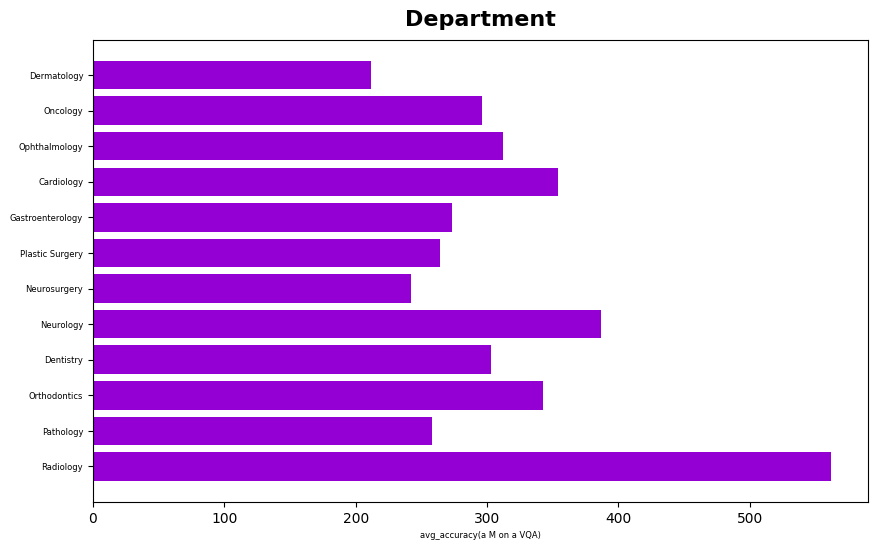

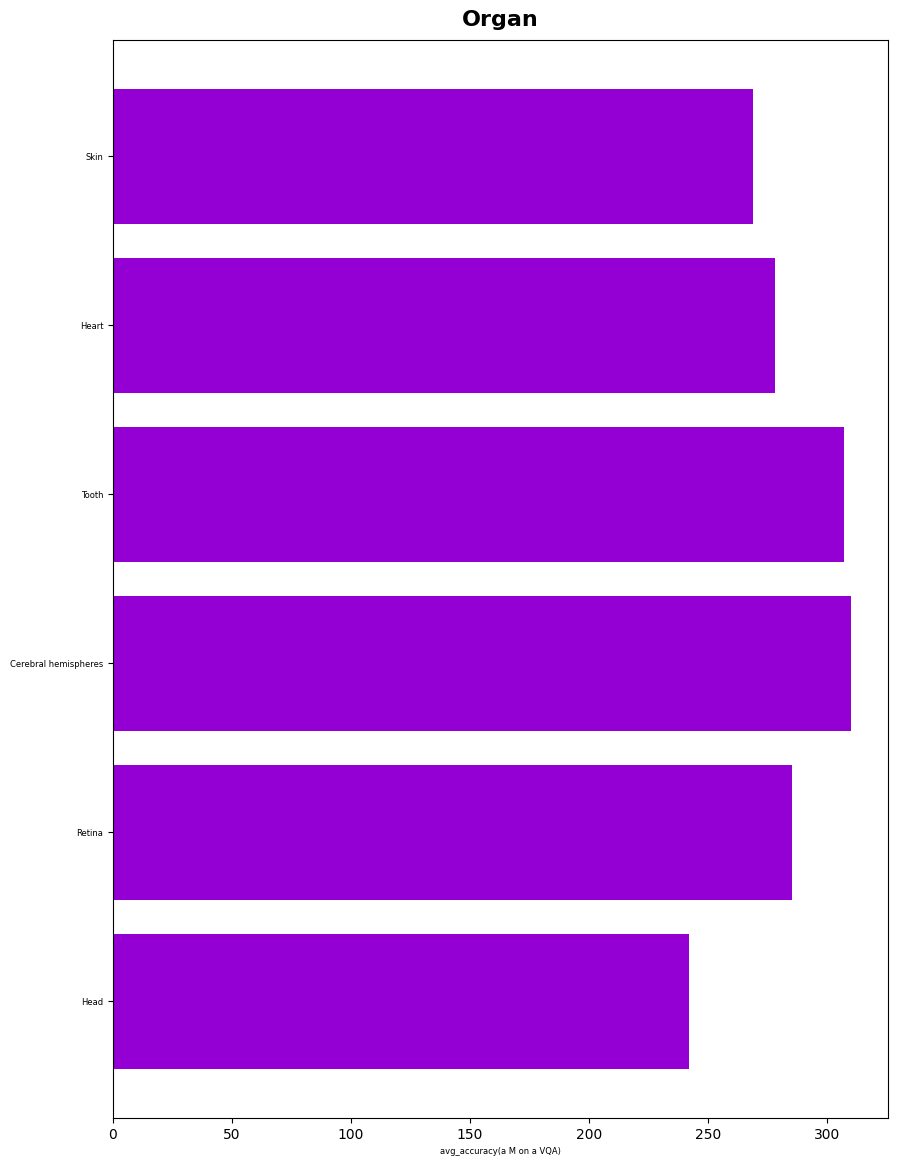

In [12]:
# number of entries
draw_barchart_level(dict_fitler, level="L1", colors="#9400D3")
draw_barchart_level(dict_fitler, level="L4", colors="#9400D3")

In [8]:
save_as_csv(SingleModel_dict, level="L1")
save_as_csv(SingleModel_dict, level="L2")
save_as_csv(SingleModel_dict, level="L3")
save_as_csv(SingleModel_dict, level="L4")

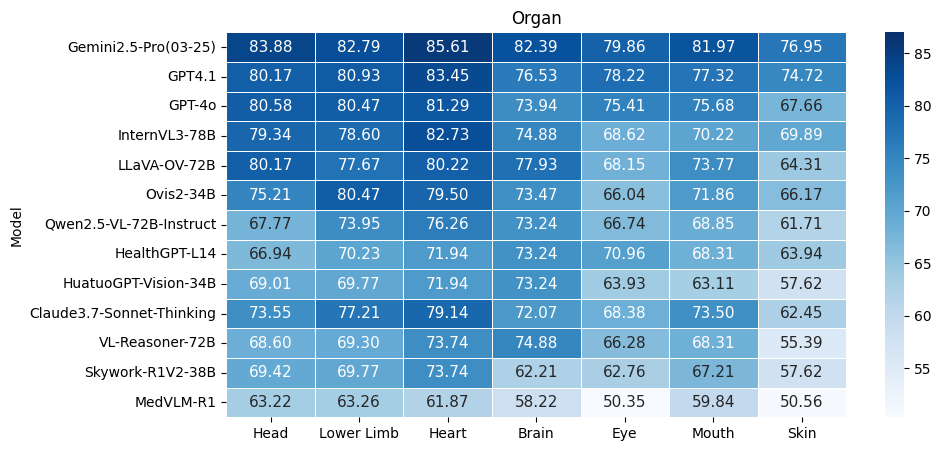

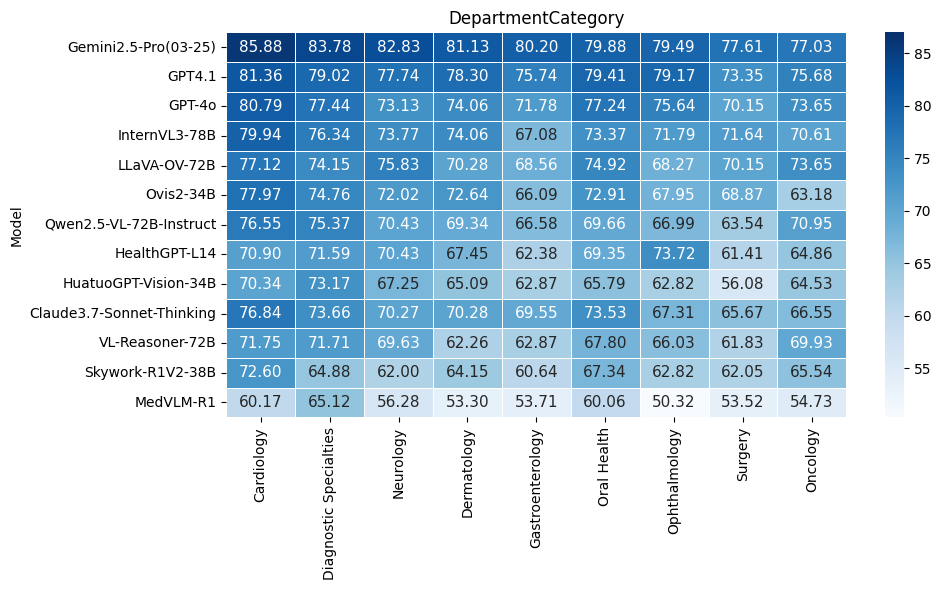

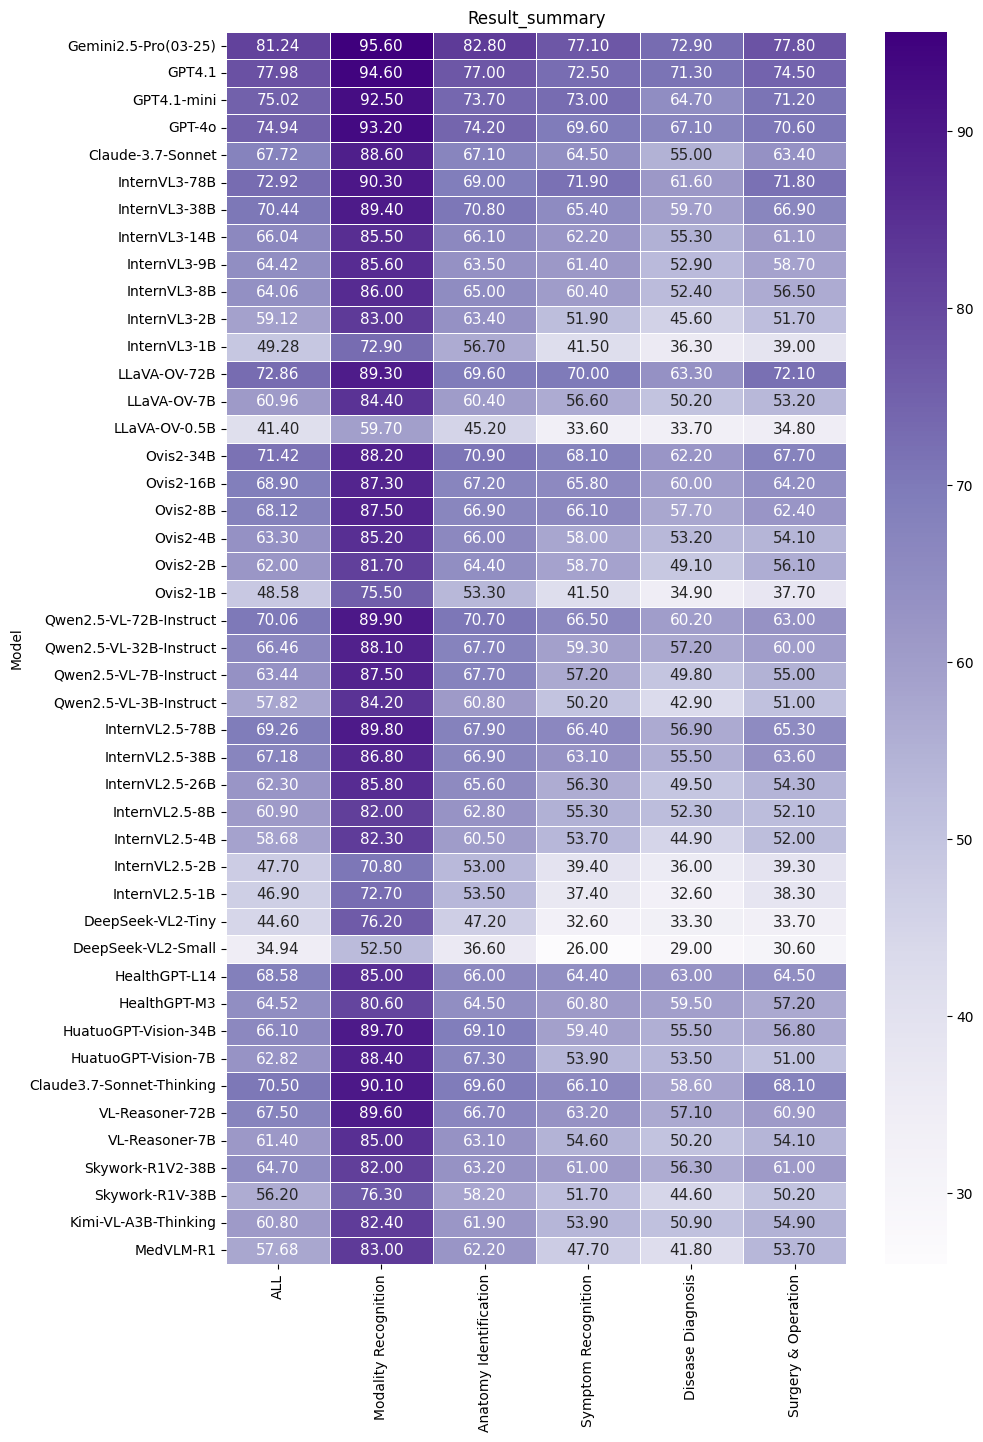

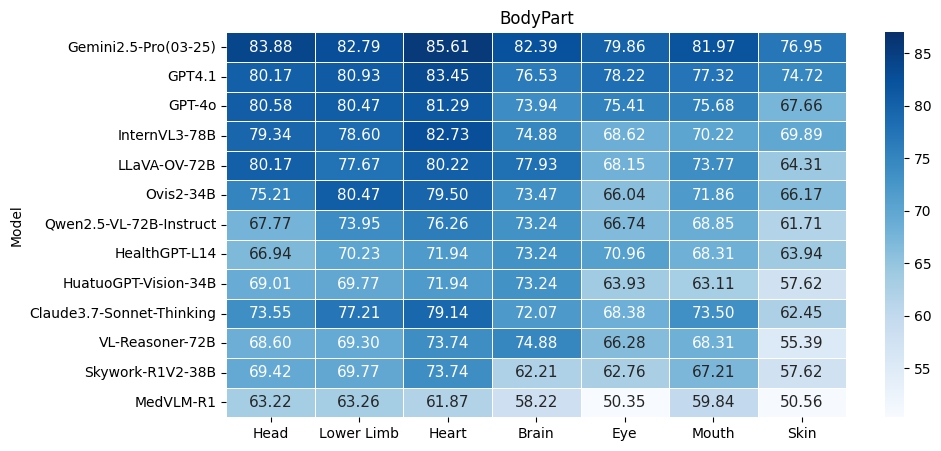

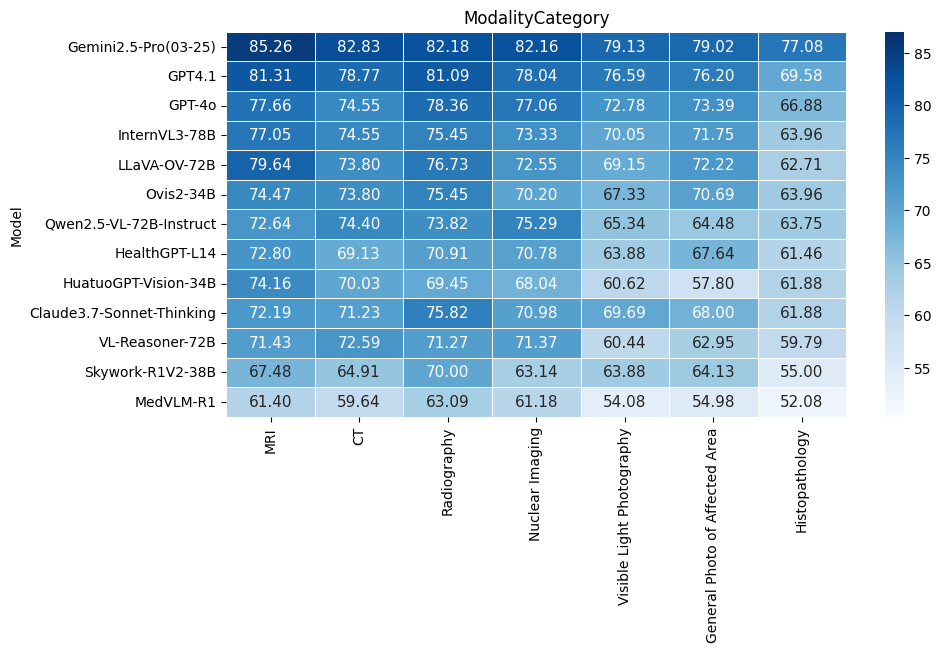

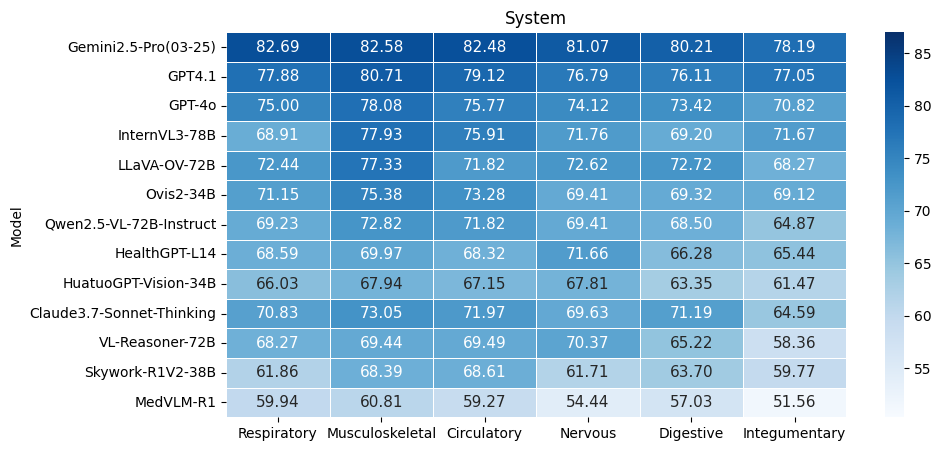

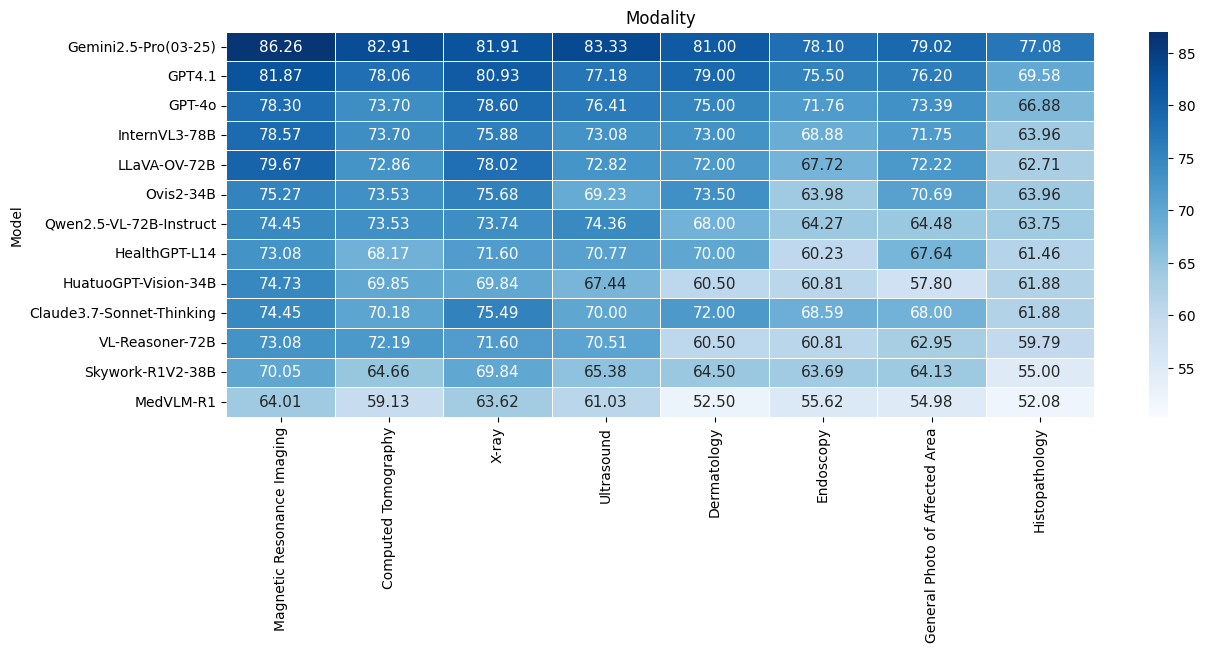

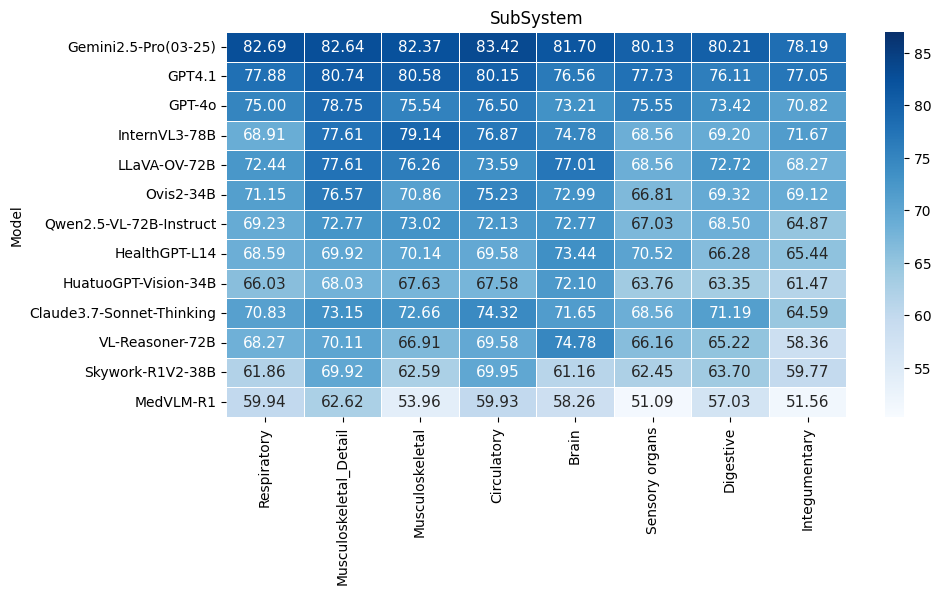

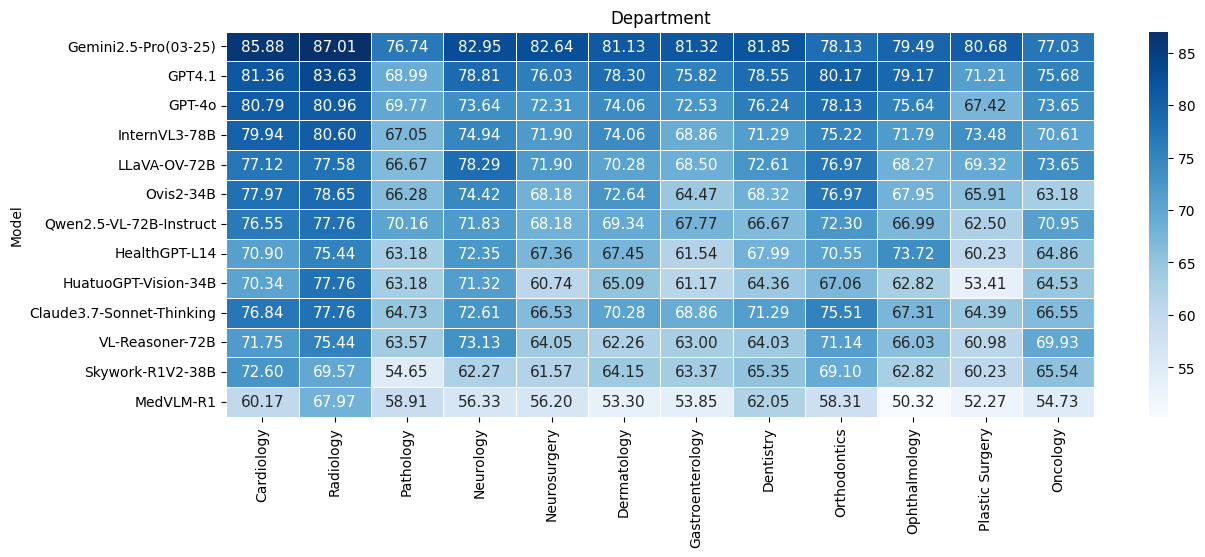

In [9]:
min_max = find_min_max()
for csv_file in os.listdir(vis_folder):
    if not csv_file.endswith(".csv"):
        continue
    if "Result_summary" in csv_file:
        visualize_csv_heatmap(os.path.join(vis_folder, csv_file), "Result_summary", cmap='Purples', figsize=(10, 16))
        continue
    if csv_file in ["Modality.csv", "Department.csv"]:
        title = os.path.splitext(csv_file)[0]
        visualize_csv_heatmap(os.path.join(vis_folder, csv_file), title, cmap='Blues', figsize=(14, 5), min_max=min_max)
        continue
    if csv_file in ["Organ.csv", "System.csv"]:
        title = os.path.splitext(csv_file)[0]
        visualize_csv_heatmap(os.path.join(vis_folder, csv_file), title, cmap='Blues', figsize=(10, 5), min_max=min_max)
        continue
    else: # "BodyPart.csv","ModalityCategory.csv" , "SubSystem.csv", "DepartmentCategory.csv"
        title = os.path.splitext(csv_file)[0]
        visualize_csv_heatmap(os.path.join(vis_folder, csv_file), title, cmap='Blues', figsize=(10, 5), min_max=min_max)
        continue